# Разработка системы распознавания предметов интерьера в потоковом видео
## Часть 7: Детекция объектов по семантической сегментации
### Воропаев Роберт, 2020

В этой части ранее обученная модель используется для построения детекции по маске, полученной на выходе из нейронной сети для семантической сегментации. Реализуются методы для построения bounding box'ов и фильтрации выбросов. В конце реализуется метод для обработки загружаемого видео.

In [1]:
%matplotlib inline

# System
import os
import sys
import datetime
import time

# Base
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from skimage.io import imread, imshow
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN

# Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dropout, BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger

# Preprocessing
from keras.utils import Sequence, to_categorical
from keras.utils.vis_utils import plot_model

# Backend
import tensorflow as tf
from keras import backend as K
from tensorflow.python.client import device_lib

# Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

Using TensorFlow backend.
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

In [2]:
from ipynb_scripts.PathFinder import PathFinder
from ipynb_scripts.SegEncoder import SegEncoder
from ipynb_scripts.ClassList import ClassList

pf = PathFinder()
se = SegEncoder()
cl = ClassList(load_class_encode=True, class_encode_path="static_data/class_encode.txt")

img_dir = 'data/ADE20K_filtred/images/'

## Загрузка модели 

In [3]:
class def_config:

    main_data_dir = "data/ADE20K_encoded/"
    callbacks_dir = "callbacks/"

    img_shape = 256
    classes_num = 17

    batch_size = 4
    epoch_num = 1
    train_coef = 1
    learning_rate = 0.0001

    last_activation = "sigmoid"
    loss_function = "categorical_crossentropy"

    layers_in_block = 3
    dropout_prob = 0.1
    
    gpu_memory_limit = 0.8
    cpu_threads_num = 4

    callbacks_monitor = "val_jaccard_coef"
    callbacks_data_format = "%m.%d_%H-%M"
    file_name = "DefName"
    
    is_load = True
    weight_path = "callbacks/Unet_1024_dropout_nearest_3_06.11_15-44/best_w_jaccard.h5"
    
    argparse_is_on = False
    
    
args = def_config()

In [4]:
main_data_dir = args.main_data_dir

train_dir = main_data_dir + "train/"
val_dir = main_data_dir + "val/"

img_train_dir = train_dir + "img/"
mask_train_dir = train_dir + "mask/"

img_val_dir = val_dir + "img/"
mask_val_dir = val_dir + "mask/"

####################################

img_shape = args.img_shape
batch_size = args.batch_size
classes_num = args.classes_num

epoch_num = args.epoch_num
train_coef = args.train_coef
learning_rate = args.learning_rate

loss_function = args.loss_function
last_activation = args.last_activation

layers_in_block = args.layers_in_block
dropout_prob = args.dropout_prob


is_load = args.is_load
if is_load:
    weight_path = args.weight_path
else:
    weight_path = None
    
train_size = len(os.listdir(path=train_dir + "img/"))
val_size = len(os.listdir(path=val_dir + "img/"))

In [5]:
def data_gen(img_dir, mask_dir, classes_num, batch_size):
    img_folder = img_dir
    mask_folder = mask_dir

    img_list = os.listdir(img_folder)
    random.shuffle(img_list)
    img_dir_size = len(img_list)

    for i in range(len(img_list)):
        img_list[i] = img_list[i].split(".")[0]  # отделяем имя от формата

    counter = 0
    while (True):
        img = np.zeros((batch_size, img_shape, img_shape, 3)).astype('float')
        mask = np.zeros((batch_size, img_shape, img_shape, classes_num)).astype("uint8")

        for i in range(counter, counter + batch_size):
            train_img = cv2.imread(img_folder + '/' + img_list[i] + ".jpg") / 255.
            train_img = cv2.resize(train_img, (img_shape, img_shape))

            img[i - counter] = train_img

            train_mask = cv2.imread(mask_folder + '/' + img_list[i] + ".png", cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.resize(train_mask, (img_shape, img_shape), interpolation=cv2.INTER_NEAREST)
            train_mask = train_mask.reshape(img_shape, img_shape, 1)
            train_mask = to_categorical(train_mask, num_classes=classes_num)

            mask[i - counter] = train_mask

        counter += batch_size

        if counter + batch_size >= img_dir_size:
            counter = 0
            random.shuffle(img_list)

        yield img, mask


train_gen = data_gen(img_train_dir, mask_train_dir, classes_num=classes_num, batch_size=batch_size)
val_gen = data_gen(img_val_dir, mask_val_dir, classes_num=classes_num, batch_size=batch_size)

In [6]:
def conv_block(filters, layers, input_layer):
    output_layer = input_layer
    
    for i in range(layers):
        output_layer = Conv2D(filters, (3, 3), padding="same")(output_layer)
        output_layer = Activation("relu")(output_layer)
    
    output_layer = Dropout(dropout_prob)(output_layer)
    return output_layer


def get_model(img_shape, classes_num, last_activation, layers_in_block):
    block0_input = Input(shape=(img_shape, img_shape, 3))
    
    block1_conv = conv_block(64, layers_in_block, block0_input)
    block1_pool = MaxPool2D(2)(block1_conv)

    block2_conv = conv_block(128, layers_in_block, block1_pool)
    block2_pool = MaxPool2D(2)(block2_conv)

    block3_conv = conv_block(256, layers_in_block, block2_pool)
    block3_pool = MaxPool2D(2)(block3_conv)
    
    block4_conv = conv_block(512, layers_in_block, block3_pool)
    block4_pool = MaxPool2D(2)(block4_conv)
    
    block5_conv = conv_block(1024, layers_in_block, block4_pool)
    block5_upsa = UpSampling2D(2, interpolation="nearest")(block5_conv)

    block6_conc = Concatenate()([block4_conv, block5_upsa])    

    block6_conv = conv_block(512, layers_in_block, block6_conc)
    block6_upsa = UpSampling2D(2, interpolation="nearest")(block6_conv)
    
    block7_conc = Concatenate()([block3_conv, block6_upsa])
    
    block7_conv = conv_block(256, layers_in_block, block7_conc)
    block7_upsa = UpSampling2D(2, interpolation="nearest")(block7_conv)

    block8_conc = Concatenate()([block2_conv, block7_upsa])
    
    block8_conv = conv_block(128, layers_in_block, block8_conc)
    block8_upsa = UpSampling2D(2, interpolation="nearest")(block8_conv)

    block9_conc = Concatenate()([block1_conv, block8_upsa])
    
    block9_conv = conv_block(64, layers_in_block, block9_conc)

    block10_output = Conv2D(classes_num, (1, 1), padding="same", activation=last_activation)(block9_conv)

    return Model(inputs=block0_input, outputs=block10_output)

In [7]:
# Модель
model = get_model(None, classes_num, last_activation, layers_in_block=layers_in_block)

model.load_weights(weight_path)

if is_load:
    if not weight_path:
        raise ValueError("Don't load weight_path")
    model.load_weights(weight_path)
    
    
# Средняя площадь классов
with open("static_data/class_areas.txt", "r") as f:
    class_area = []
    for line in f:
        index, area, name = line.split("\t")
        class_area.append(float(area))

## Предсказания

#### Функции для получения предсказаний и объектных масок 

In [8]:
path = val_dir + "/img/00001152.jpg"

#оригинальное изображение
original = cv2.imread(path)
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

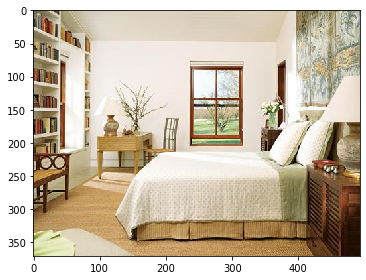

In [9]:
imshow(original_rgb)
plt.show()

In [10]:
# предсказания на выходе из сети
def get_predict(original_img,  clipping=0.5):
    img = cv2.resize(original_img / 255., (img_shape, img_shape))
    pred = model.predict(np.array([img]))[0]
    return pred
    
# предсказания оригинального размера
def get_resize_predict(original_img, clipping=0.5):
    h, w, c = original_img.shape
    pred = get_predict(original_img, clipping)
    return cv2.resize(pred, (w, h))

# маска оригинального размера определенного класса
def get_resize_mask(original_img, class_num, clipping=0.5):
    pred = get_resize_predict(original_img, clipping)
    return pred[:, :, class_num]

In [11]:
# Относительнаня площадь маски (доля занятой объектом маски)
def get_relative_area(mask):
    return mask.sum() / mask.shape[0] / mask.shape[1]

### Порог для вероятности 

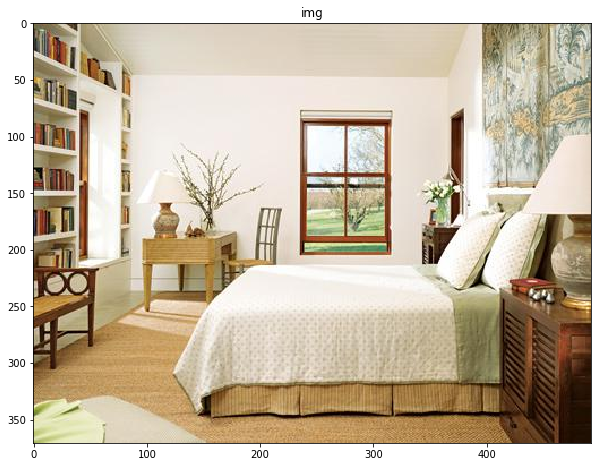

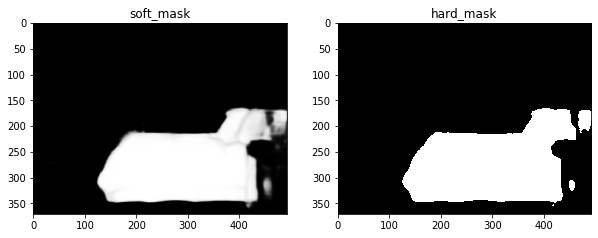

In [12]:
mask = get_resize_mask(original, 7)

# Изображение
plt.figure(figsize=(10, 10))
plt.imshow(original_rgb), plt.title("img")
plt.show()

# Маски
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(mask, "gray"), plt.title("soft_mask")
plt.subplot(122), plt.imshow(mask > 0.5, "gray"), plt.title('hard_mask')
plt.show()

### Совмещение масок и изображения 

In [13]:
def get_new_img(original_img, clipping=0.5, class_area_coef=0.5, is_rgb=True):
    h, w, c = original_img.shape

    pred = get_predict(original_img, clipping)
    
    new_img = original_img.copy()
    
    for i in range(1, classes_num):
        mask = pred[:, :, i]

        if get_relative_area(mask) < class_area[i] * class_area_coef:
            continue

        print(cl.class_list[i])
        print(get_relative_area(mask), "-", class_area[i])

        mask = cv2.resize(mask, (w, h))
        mask = (mask > clipping).astype(np.uint8)
        
        neg = 1 - mask

        index = i % 3
        free = [0, 1, 2]
        free.remove(index)
        
        new_img[:, :, index] += mask*255
        new_img[:, :, free[0]] *= neg
        new_img[:, :, free[1]] *= neg

        new_img = np.clip(new_img, 0, 255)
    
    if is_rgb:
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    return new_img

['table', 'desk']
0.04876049607992172 - 0.05857641754989444
['bed', 'sofa, couch, lounge', 'cushion', 'pillow']
0.23124028742313385 - 0.18965312282745642


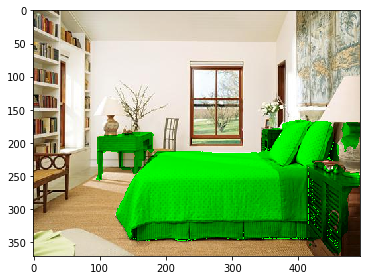

In [14]:
imshow(get_new_img(original))
plt.show()

## Получение рамки

In [15]:
# цвета
blue = (255, 0, 0)
green = (0, 255, 0)
red = (0, 0, 255)
color = [blue, green, red]

In [16]:
# получение границ 
def get_border(mask):
    x, y = np.where(mask == 1)
    
    down = x.min()
    up = x.max()

    left = y.min()
    right = y.max()
    
    return down, up, left, right

In [17]:
def get_new_img_with_border(original_img, clipping=0.5, class_area_coef=0.5):
    h, w, c = original_img.shape
    
    pred = get_predict(original_img, clipping)
    
    new_img = original_img.copy()
    
    index_border_color = dict()
    
    free_color = [0, 1, 2]
    for i in range(1, classes_num):
        mask = pred[:, :, i]

        if get_relative_area(mask) < class_area[i] * class_area_coef:
            continue

        mask = cv2.resize(mask, (w, h))
        
        mask = (mask > clipping).astype(np.uint8)
        down, up, left, right = get_border(mask)
        
        neg = 1 - mask

        color_index = i % 3
        if color_index in free_color:
            free_color.remove(color_index)
            if len(free_color) == 0:
                free_color = [0, 1, 2]
        else:
            color_index = free_color[0]
        index_border_color[i] = [down, up, left, right, color_index]
            
        free = [0, 1, 2]
        free.remove(color_index)
        new_img[:, :, color_index] += mask*255
        new_img[:, :, free[0]] *= neg
        new_img[:, :, free[1]] *= neg

        new_img = np.clip(new_img, 0, 255)
    return new_img, index_border_color

{4: [178, 368, 95, 492, 1], 7: [165, 355, 125, 492, 0]}


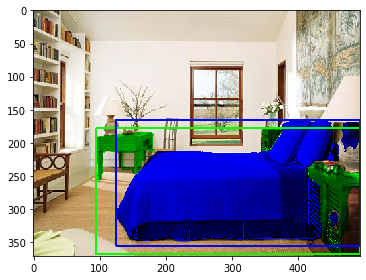

In [18]:
new_img, index_border = get_new_img_with_border(original)

print(index_border)

for class_index in index_border:
    down, up, left, right, color_index  = index_border[class_index]
    cv2.rectangle(new_img, (right, up), (left, down), 
                color[color_index], thickness=2, lineType=8, shift=0)

new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
imshow(new_img)
plt.show()

## Выбросы 

### Исключение выбросов по квантилям

In [19]:
def get_quantile(mask, alpha = 0.02):
    x, y = np.where(mask == 1)
    
    down = int(np.quantile(x, q=alpha))
    up = int(np.quantile(x, q=1-alpha))

    left = int(np.quantile(y, q=alpha))
    right = int(np.quantile(y, q=1-alpha))
    
    return down, up, left, right

def get_filt_mask(mask, border):
    filt_mask = mask.copy()
    down, up, left, right = border
    filt_mask[:down, :] = filt_mask[up:, :] = filt_mask[:, :left] = filt_mask[:, right:] = 0
    return filt_mask

/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


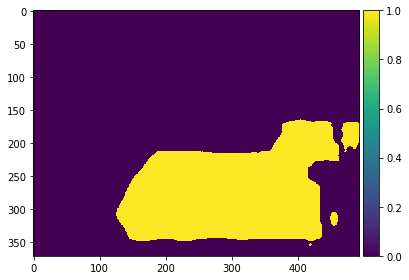

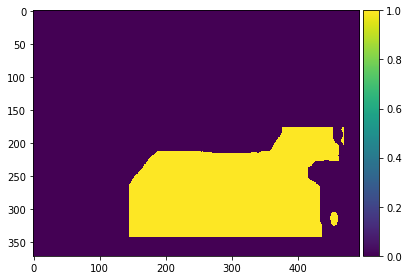

In [20]:
mask = get_resize_mask(original, 7)
mask = (mask > 0.5).astype(np.uint8)

imshow(mask)
plt.show()

filt_mask = get_filt_mask(mask, get_quantile(mask))

imshow(filt_mask)
plt.show()

In [21]:
def get_new_img_with_quantile(original_img, clipping=0.5, class_area_coef=0.5, quantile_alpha=0.02):
    h, w, c = original_img.shape

    pred = get_predict(original_img, clipping)
    
    new_img = original_img.copy()
    
    index_border_color = dict()
    free_color = [0, 1, 2]
    for i in range(1, classes_num):
        mask = pred[:, :, i]

        if get_relative_area(mask) < class_area[i] * class_area_coef:
            continue

        mask = cv2.resize(mask, (w, h))
        
        mask = (mask > clipping).astype(np.uint8)
        
        down, up, left, right = get_quantile(mask, quantile_alpha)
        mask = get_filt_mask(mask, [down, up, left, right])
        
        neg = 1 - mask

        color_index = i % 3
        if color_index in free_color:
            free_color.remove(color_index)
            if len(free_color) == 0:
                free_color = [0, 1, 2]
        else:
            color_index = free_color[0]
        index_border_color[i] = [down, up, left, right, color_index]
            
        free = [0, 1, 2]
        free.remove(color_index)
        new_img[:, :, color_index] += mask*255
        new_img[:, :, free[0]] *= neg
        new_img[:, :, free[1]] *= neg

        new_img = np.clip(new_img, 0, 255)
    return new_img, index_border_color

{4: [184, 356, 100, 483, 1], 7: [176, 343, 145, 469, 0]}


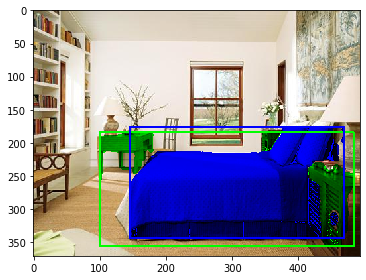

In [22]:
new_img, index_border = get_new_img_with_quantile(original)

print(index_border)

for class_index in index_border:
    down, up, left, right, color_index  = index_border[class_index]
    cv2.rectangle(new_img, (right, up), (left, down), 
                color[color_index], thickness=2, lineType=8, shift=0)

new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
imshow(new_img)
plt.show()

## Кластеризация

In [23]:
def get_dbscan_mask(mask, eps=1):
    x,y = np.where(mask == 1)

    arr = np.empty((x.shape[0], 2), dtype=np.uint(8))
    arr[:, 0] = x
    arr[:, 1] = y

    clustering = DBSCAN(eps=eps, min_samples=1).fit(arr)

    target = stats.mode(clustering.labels_).mode[0]
    new_mask = np.zeros(mask.shape, dtype=np.uint8)

    for i in range(len(arr)):
        xx, yy = arr[i]
        new_mask[xx, yy] = clustering.labels_[i] + 1
    return new_mask


/home/rv/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


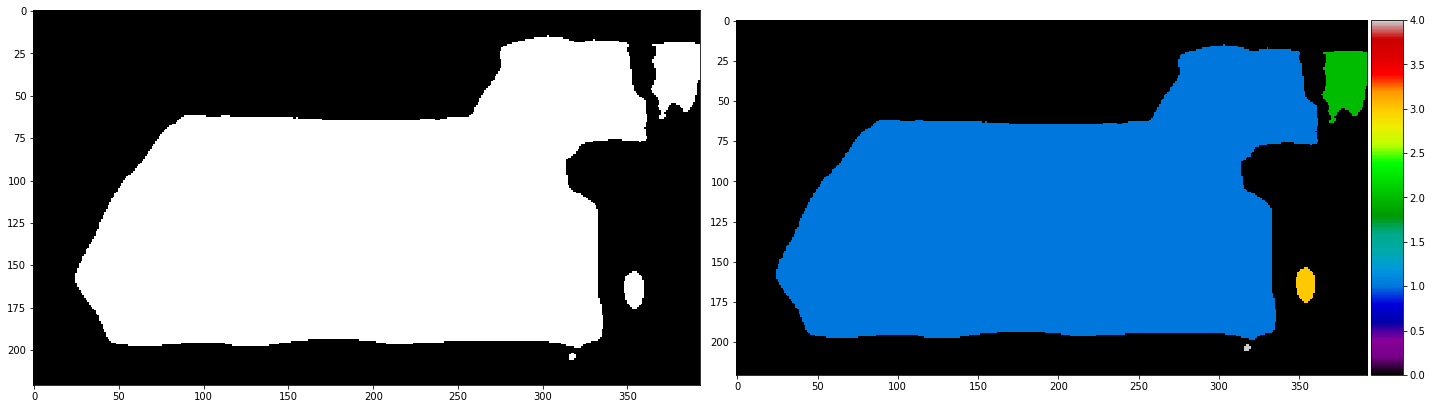

In [24]:
plt.figure(figsize=(20, 40))

mask = get_resize_mask(original, 7)
mask = (mask > 0.5).astype(np.uint8)

plt.subplot(121)
imshow(mask[150:, 100:] > 0.5)

plt.subplot(122)
imshow(get_dbscan_mask(mask)[150:, 100:], cmap="nipy_spectral")

### Выделение нескольких реализаций 

In [25]:
def get_dbscan_filt_mask(db_mask, class_index, min_area_coef=1 / 10.):
    min_area = class_area[class_index] * min_area_coef
    db_mask_area = db_mask.shape[0] * db_mask.shape[1]
    
    label, count = np.unique(db_mask, return_counts=True)

    delete = []
    obj_labels = []
    for i in range(1, len(label)):
        if count[i] / db_mask_area < min_area:
            delete.append(label[i])
        else:
            obj_labels.append(label[i])

    new_mask = db_mask
    for class_index in delete:
        new_mask = np.where(new_mask != class_index, new_mask, 0)
    return new_mask, obj_labels

In [26]:
def get_border(mask, index=1):
    x, y = np.where(mask == index)

    down = x.min()
    up = x.max()

    left = y.min()
    right = y.max()

    return down, up, left, right

def get_detection_img(original_img, 
                      clipping=0.5, class_area_coef=0.5,
                      db_eps=1, min_area_coef=1 / 10.):
    h, w, c = original_img.shape

    pred = get_predict(original_img, clipping)

    new_img = original_img.copy()

    index_to_color_borders_dict = dict()
    free_color = [0, 1, 2]
    for i in range(1, classes_num):

        mask = pred[:, :, i]

        if get_relative_area(mask) < class_area[i] * class_area_coef:
            continue

        mask = (mask > clipping).astype(np.uint8)
        mask = get_dbscan_mask(mask, db_eps)
        mask, obj_labels = get_dbscan_filt_mask(mask, class_index=i, min_area_coef=min_area_coef)

        mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

        index_to_color_borders_dict[i] = [0, []]

        for obj in obj_labels:
            index_to_color_borders_dict[i][1].append(get_border(mask, obj))

        mask = np.where(mask == 0, mask, 1)
        neg = 1 - mask

        color_index = i % 3
        if color_index in free_color:
            free_color.remove(color_index)
            if len(free_color) == 0:
                free_color = [0, 1, 2]
        else:
            color_index = free_color[0]
        index_to_color_borders_dict[i][0] = color_index

        free = [0, 1, 2]
        free.remove(color_index)
        new_img[:, :, color_index] += mask * 255
        new_img[:, :, free[0]] *= neg
        new_img[:, :, free[1]] *= neg
        new_img = np.clip(new_img, 0, 255)

    return new_img, index_to_color_borders_dict

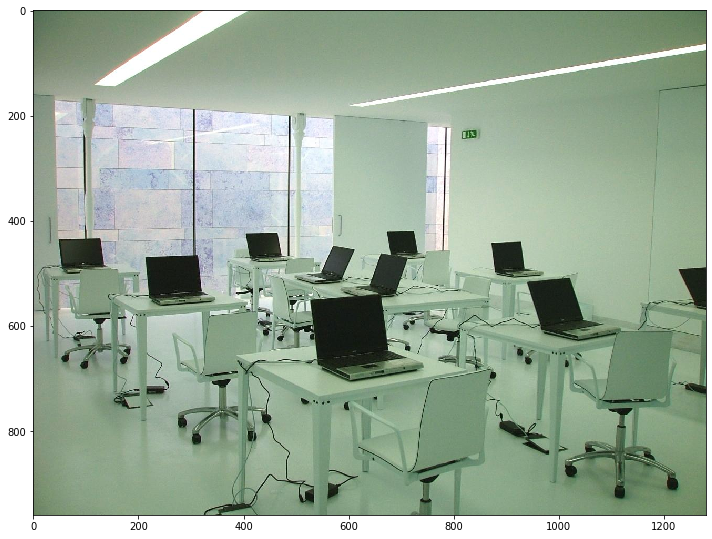

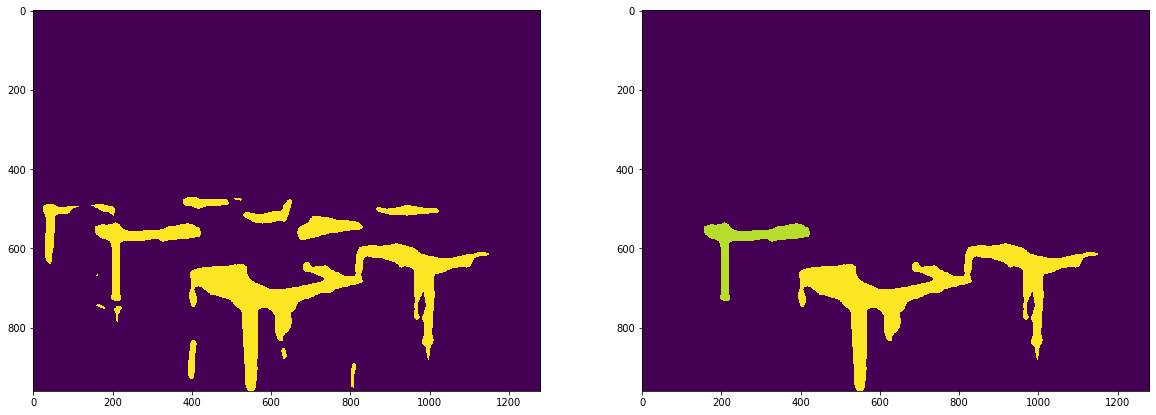

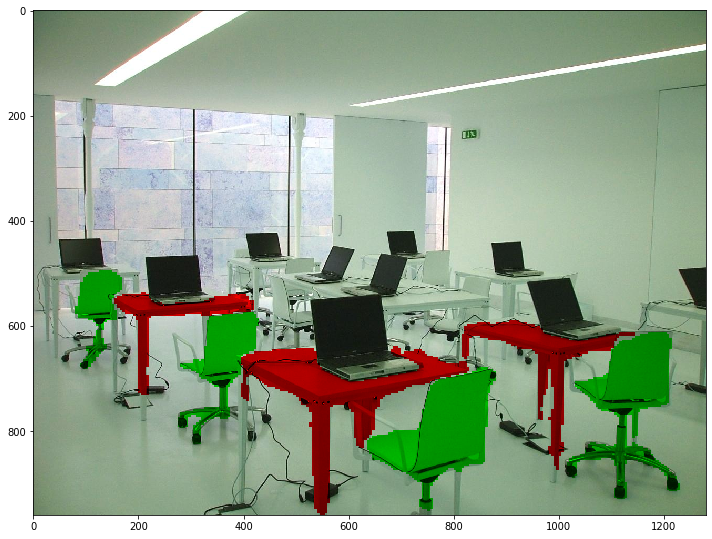

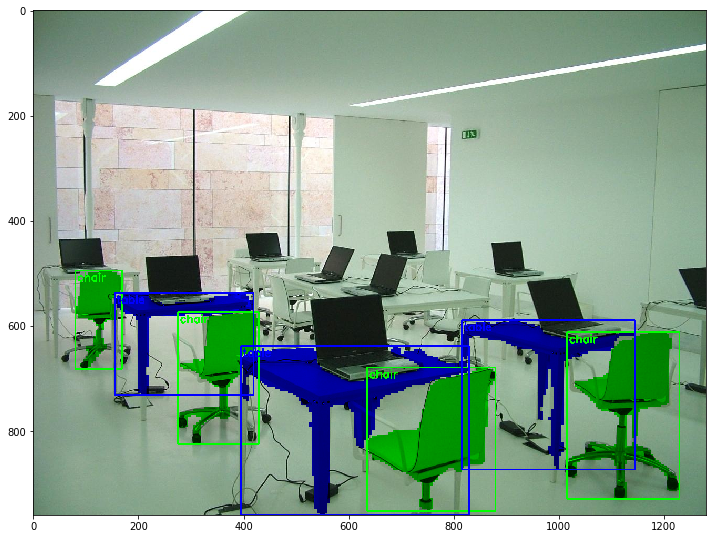

In [27]:
path = train_dir + "/img/00005948.jpg" #00005948 #00000156 #00000157 #00000515 #00000516 #00000932 
#00000961 #00001066 #00001943
original = cv2.imread(path)
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

clipping=0.6
class_area_coef=0.5
db_eps=1
min_area_coef=1/10.

plt.figure(figsize=(10, 20))
imshow(original)
plt.show()

class_index = 4
mask = get_resize_mask(original, class_index)
mask = (mask > 0.5).astype(np.uint8)

db_mask = get_dbscan_mask(mask)
filt_mask, labels = get_dbscan_filt_mask(db_mask, class_index=class_index, min_area_coef=min_area_coef)


plt.figure(figsize=(20, 40))
plt.subplot(121)
plt.imshow(db_mask != 0)
plt.subplot(122)
plt.imshow(filt_mask)
plt.show()



new_img, index_border_color = get_detection_img(original, 
                                    clipping=clipping, 
                                    class_area_coef=class_area_coef, 
                                    min_area_coef=min_area_coef)

plt.figure(figsize=(10, 20))
imshow(new_img)
plt.show()


for class_num, color_objects in index_border_color.items():
    color_index, objects = color_objects
    for obj in objects:
        down, up, left, right = obj

        cv2.rectangle(new_img, (right, up), (left, down), 
                      color[color_index], thickness=2, lineType=8, shift=0)
        cv2.putText(new_img, str(cl.class_list[class_num][0]), (left + 4, down + 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color[color_index], 2)

plt.figure(figsize=(10, 20))
imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.show()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


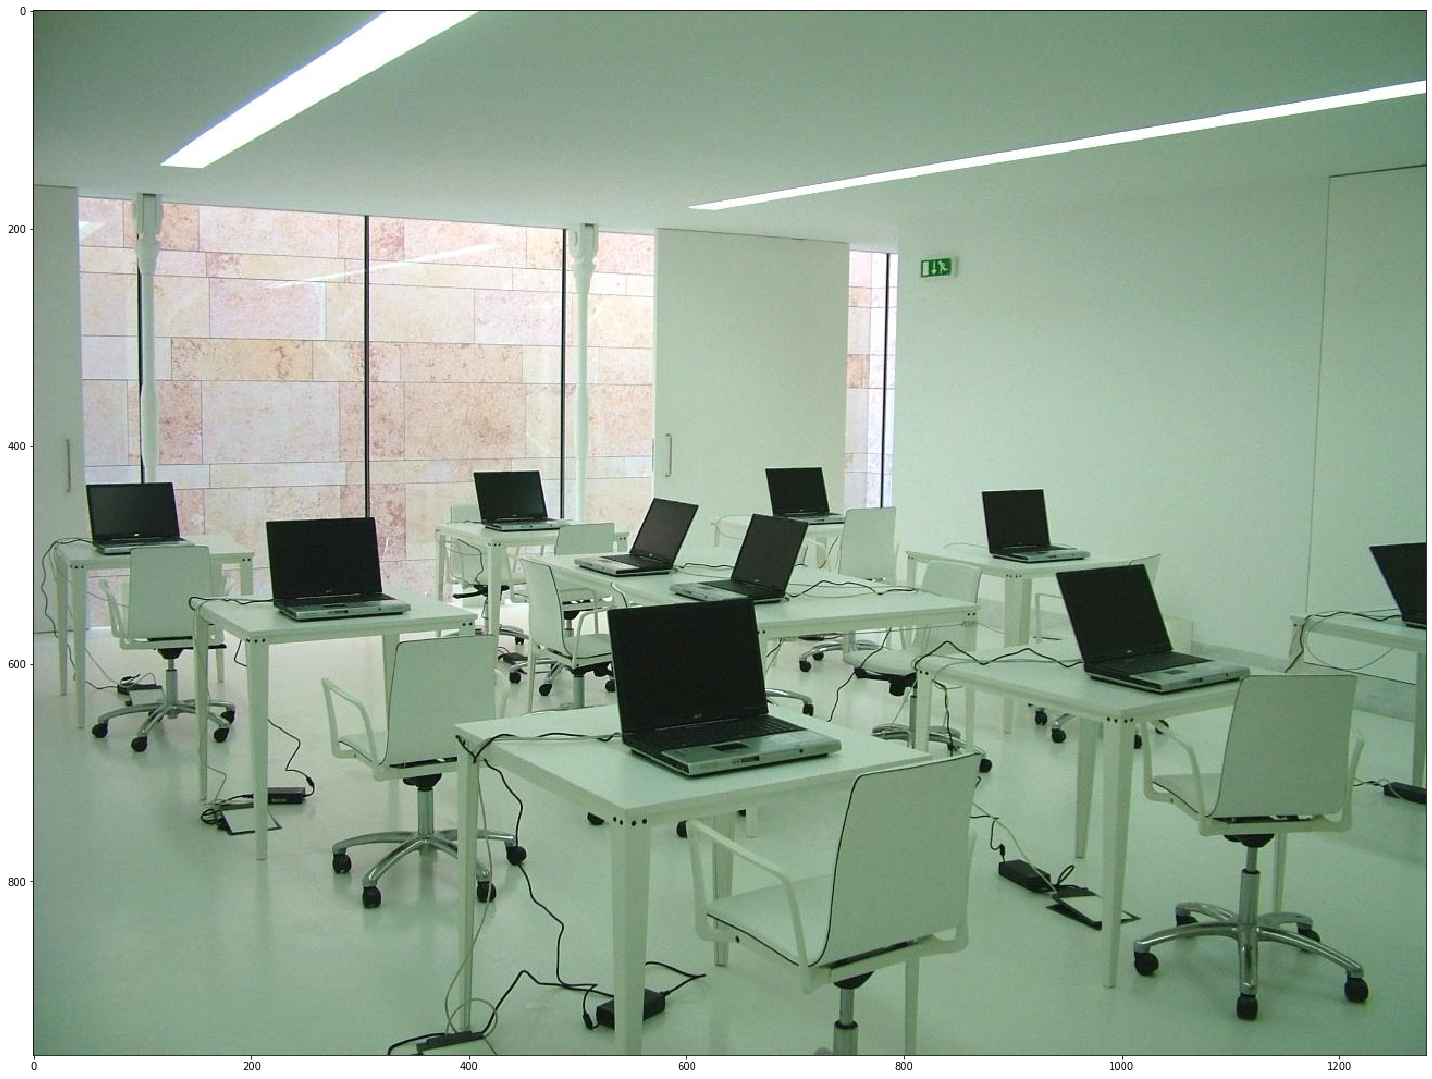

In [28]:
%time
blue = (255, 0, 0)
green = (0, 255, 0)
red = (0, 0, 255)
color = [blue, green, red]

clipping=0.6
class_area_coef=0.5
db_eps=1
min_area_coef=1/1.
new_img, index_border_color = get_detection_img(original, 
                                    clipping=clipping, 
                                    class_area_coef=class_area_coef, 
                                    min_area_coef=min_area_coef)

for class_num, color_objects in index_border_color.items():
    color_index, objects = color_objects
    for obj in objects:
        down, up, left, right = obj

        cv2.rectangle(new_img, (right, up), (left, down), 
                      color[color_index], thickness=2, lineType=8, shift=0)
        cv2.putText(new_img, str(cl.class_list[class_num][0]), (left + 4, down + 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color[color_index], 2)

plt.figure(figsize=(20, 40))
imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.show()

## Обработка видео 

In [33]:
def process_video(video_in, video_out, 
                  fps=10, video_shape=(1280, 720),
                  clipping=0.5, class_area_coef=0.5,
                  db_eps=1, min_area_coef=1 / 10.):
    cap = cv2.VideoCapture(video_in)

    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    out = cv2.VideoWriter(video_out, fourcc, fps, video_shape)

    frame_count = 0
    while (cap.isOpened()):
        frame_count += 1
        ret, frame = cap.read()
        if not ret:
            break

        new_img, index_to_color_borders_dict = get_detection_img(
            frame,
            clipping=clipping,
            class_area_coef=class_area_coef,
            db_eps=db_eps,
            min_area_coef=min_area_coef)

        for class_num, color_objects in index_to_color_borders_dict.items():
            color_index, objects = color_objects
            for obj in objects:
                down, up, left, right = obj

                cv2.rectangle(new_img,
                              (right, up), (left, down),
                              color[color_index], thickness=2,
                              lineType=8, shift=0)

                cv2.putText(new_img, str(cl.class_list[class_num][0]),
                            (left + 4, down + 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7,
                            color[color_index], 2)

        cv2.imshow('frame', new_img)
        out.write(new_img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    out.release()
    cap.release()
    cv2.destroyAllWindows()
    return frame_count


In [37]:
process_video(video_in="data/video_in/" + "test_k3.mp4", 
              video_out="data/video_out/" + "__test_k3.avi", 
              fps=10, clipping=0.5, class_area_coef=0.75, db_eps=1, min_area_coef=1/5.)

(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 

(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 848, 3)
(480, 

AttributeError: 'NoneType' object has no attribute 'shape'